In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.layers import Masking, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

#Load Data

In [4]:
data=pd.read_table('/content/spa.txt')

In [5]:
data.head()

,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
0,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Run!,¡Corre!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [6]:
data = data.rename(columns={'Go.':'eng', 'Ve.':'spa'})
X = data['eng'].apply(lambda x:x.lower())
y = data['spa'].apply(lambda x:x.lower())
X = X.apply(lambda x:re.sub("[^a-zA-Z]"," ",x))
y = y.apply(lambda x:re.sub("[^a-zA-Z]"," ",x))
y = y.apply(lambda x:'START_ '+x+' _END')


In [7]:
eng_vocab=[]
spa_vocab=[]
for sent in X:
  for word in sent.split():
    if word not in eng_vocab:
      eng_vocab.append(word)
for sent in y:
 for word in sent.split():
  if word not in spa_vocab:
    spa_vocab.append(word)
engVocab = sorted(eng_vocab)
spaVocab = sorted(spa_vocab)

Encoder

In [8]:
eng_word2idx = dict([(word, i+1) for i, word in enumerate(engVocab)])
spa_word2idx = dict([(word, i+1) for i, word in enumerate(spaVocab)])


In [9]:
eng_word2idx

{'a': 1,
 'aback': 2,
 'abandon': 3,
 'abandoned': 4,
 'abated': 5,
 'abc': 6,
 'abducted': 7,
 'aberration': 8,
 'abhor': 9,
 'abiding': 10,
 'abilities': 11,
 'ability': 12,
 'able': 13,
 'aboard': 14,
 'about': 15,
 'above': 16,
 'abroad': 17,
 'abrupt': 18,
 'absence': 19,
 'absent': 20,
 'absentmindedly': 21,
 'absolute': 22,
 'absolutely': 23,
 'absorb': 24,
 'absorbs': 25,
 'abstained': 26,
 'absurd': 27,
 'abuse': 28,
 'abused': 29,
 'abuses': 30,
 'academic': 31,
 'accelerated': 32,
 'accent': 33,
 'accept': 34,
 'acceptable': 35,
 'accepted': 36,
 'accident': 37,
 'accidentally': 38,
 'accidents': 39,
 'accompany': 40,
 'accomplish': 41,
 'accomplished': 42,
 'accomplishment': 43,
 'accordion': 44,
 'account': 45,
 'accountant': 46,
 'accounts': 47,
 'accumulated': 48,
 'accurate': 49,
 'accusation': 50,
 'accusations': 51,
 'accused': 52,
 'accustomed': 53,
 'ace': 54,
 'ache': 55,
 'ached': 56,
 'aches': 57,
 'achieve': 58,
 'achieved': 59,
 'aching': 60,
 'acid': 61,
 'ack

Decoder

In [10]:
eng_idx2word= dict([(i, word) for word, i in  eng_word2idx.items()])
spa_idx2word =dict([(i, word) for word, i in spa_word2idx.items()])


In [11]:
eng_idx2word

{1: 'a',
 2: 'aback',
 3: 'abandon',
 4: 'abandoned',
 5: 'abated',
 6: 'abc',
 7: 'abducted',
 8: 'aberration',
 9: 'abhor',
 10: 'abiding',
 11: 'abilities',
 12: 'ability',
 13: 'able',
 14: 'aboard',
 15: 'about',
 16: 'above',
 17: 'abroad',
 18: 'abrupt',
 19: 'absence',
 20: 'absent',
 21: 'absentmindedly',
 22: 'absolute',
 23: 'absolutely',
 24: 'absorb',
 25: 'absorbs',
 26: 'abstained',
 27: 'absurd',
 28: 'abuse',
 29: 'abused',
 30: 'abuses',
 31: 'academic',
 32: 'accelerated',
 33: 'accent',
 34: 'accept',
 35: 'acceptable',
 36: 'accepted',
 37: 'accident',
 38: 'accidentally',
 39: 'accidents',
 40: 'accompany',
 41: 'accomplish',
 42: 'accomplished',
 43: 'accomplishment',
 44: 'accordion',
 45: 'account',
 46: 'accountant',
 47: 'accounts',
 48: 'accumulated',
 49: 'accurate',
 50: 'accusation',
 51: 'accusations',
 52: 'accused',
 53: 'accustomed',
 54: 'ace',
 55: 'ache',
 56: 'ached',
 57: 'aches',
 58: 'achieve',
 59: 'achieved',
 60: 'aching',
 61: 'acid',
 62: 

Split Data

In [12]:
X, y = shuffle(X, y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [13]:
num_encoder_tokens = len(engVocab)
num_decoder_tokens = len(spaVocab)+1

In [14]:
num_encoder_tokens

7343

In [15]:
num_decoder_tokens

13198

In [16]:
source_length_list=[]
for l in X:
    source_length_list.append(len(l.split(' ')))
max_eng_sent_length= max(source_length_list)

target_length_list=[]
for l in y:
    target_length_list.append(len(l.split(' ')))
max_spa_sent_length= max(target_length_list)

In [17]:
def generate_batch(X=x_train, y=y_train, batch_size=128):
  while True:
    for i in range(0, len(X), batch_size):
      encoder_input_data = np.zeros(shape=(batch_size, max_eng_sent_length), dtype="float32")
      decoder_input_data = np.zeros(shape=(batch_size, max_spa_sent_length), dtype="float32")
      decoder_output_data = np.zeros(shape=(batch_size, max_spa_sent_length, num_decoder_tokens), dtype="float32")
      for j, (input_text, target_text) in enumerate(zip(X[i:i+batch_size], y[i:i+batch_size])):
        for k, word in enumerate(input_text.split()):
          encoder_input_data[j, k] = eng_word2idx[word]
        for k, word in enumerate(target_text.split()):
          if k < len(target_text.split())-1:
            decoder_input_data[j, k] = spa_word2idx[word]
          if k > 0:
            decoder_output_data[j, k-1, spa_word2idx[word]] = 1
      yield([encoder_input_data, decoder_input_data], decoder_output_data)


In [18]:
train_samples = len(x_train)
val_samples = len(x_test)
batch_size = 128
latent_dim=256

Build Encoder Model

In [19]:
encoder_inputs = Input(shape=(None,))
enc_emb_layer = Embedding(num_encoder_tokens, latent_dim, mask_zero=True)(encoder_inputs)
enc_lstm_layer = LSTM(units=latent_dim, return_state=True)
encoder_outputs, h_state, c_state = enc_lstm_layer(enc_emb_layer)
encoder_states = [h_state, c_state]


Build Decoder Model

In [20]:
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
dec_lstm_layer = LSTM(units=latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = dec_lstm_layer(dec_emb, initial_state=encoder_states)
dec_dense = Dense(units=num_decoder_tokens, activation="softmax")
decoder_outputs = dec_dense(decoder_outputs)


In [26]:
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Training Model

In [ ]:
hist = model.fit(generate_batch(X=x_train, y=y_train),
                           steps_per_epoch=train_samples//batch_size,
                           epochs=20,
                           verbose=1,
                           validation_data=generate_batch(X=x_test, y=y_test),
                           validation_steps=val_samples//batch_size)

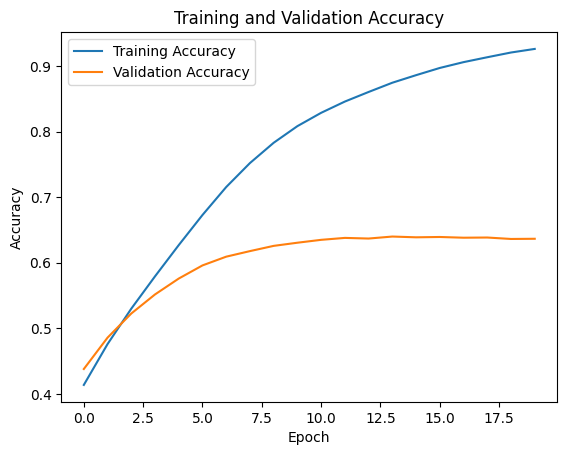

In [30]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
